In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../source/')
from DataProcessor import DataProcessor

In [2]:
fridayDataSet: pd.DataFrame = pd.read_csv(
    "../verisetleri/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)

In [3]:
fridayDataSet[" Label"].unique()

array(['BENIGN', 'DDoS'], dtype=object)

In [4]:
dataProcessor: DataProcessor = DataProcessor(fridayDataSet)
scaledData = dataProcessor.min_max_scaler(fridayDataSet)
print("Include NaN: ", np.any(np.isnan(scaledData.drop([" Label"], axis=1))))

Include NaN:  False


In [5]:
bestFeatureFrame = dataProcessor.chi_square_feature_selector(scaledData)
bestFeatures = bestFeatureFrame.Specs

Output of ChiSquare Feature Selector
                      Specs         Score
43           URG Flag Count  41617.123081
0          Destination Port  39345.753421
10    Bwd Packet Length Max  32325.617363
13    Bwd Packet Length Std  22329.356165
12   Bwd Packet Length Mean  19963.264339
48     Avg Bwd Segment Size  19963.264339
34        Max Packet Length  14957.905366
35       Packet Length Mean  14596.850204
23            Bwd IAT Total  14066.375959
36        Packet Length Std  13947.536377


In [6]:
corrDataframe  = pd.concat([scaledData[bestFeatures], scaledData[" Label"]], axis = 1)
corrDataframe = corrDataframe.reset_index()

In [7]:
corrDataframe = dataProcessor.label_encoder(corrDataframe)

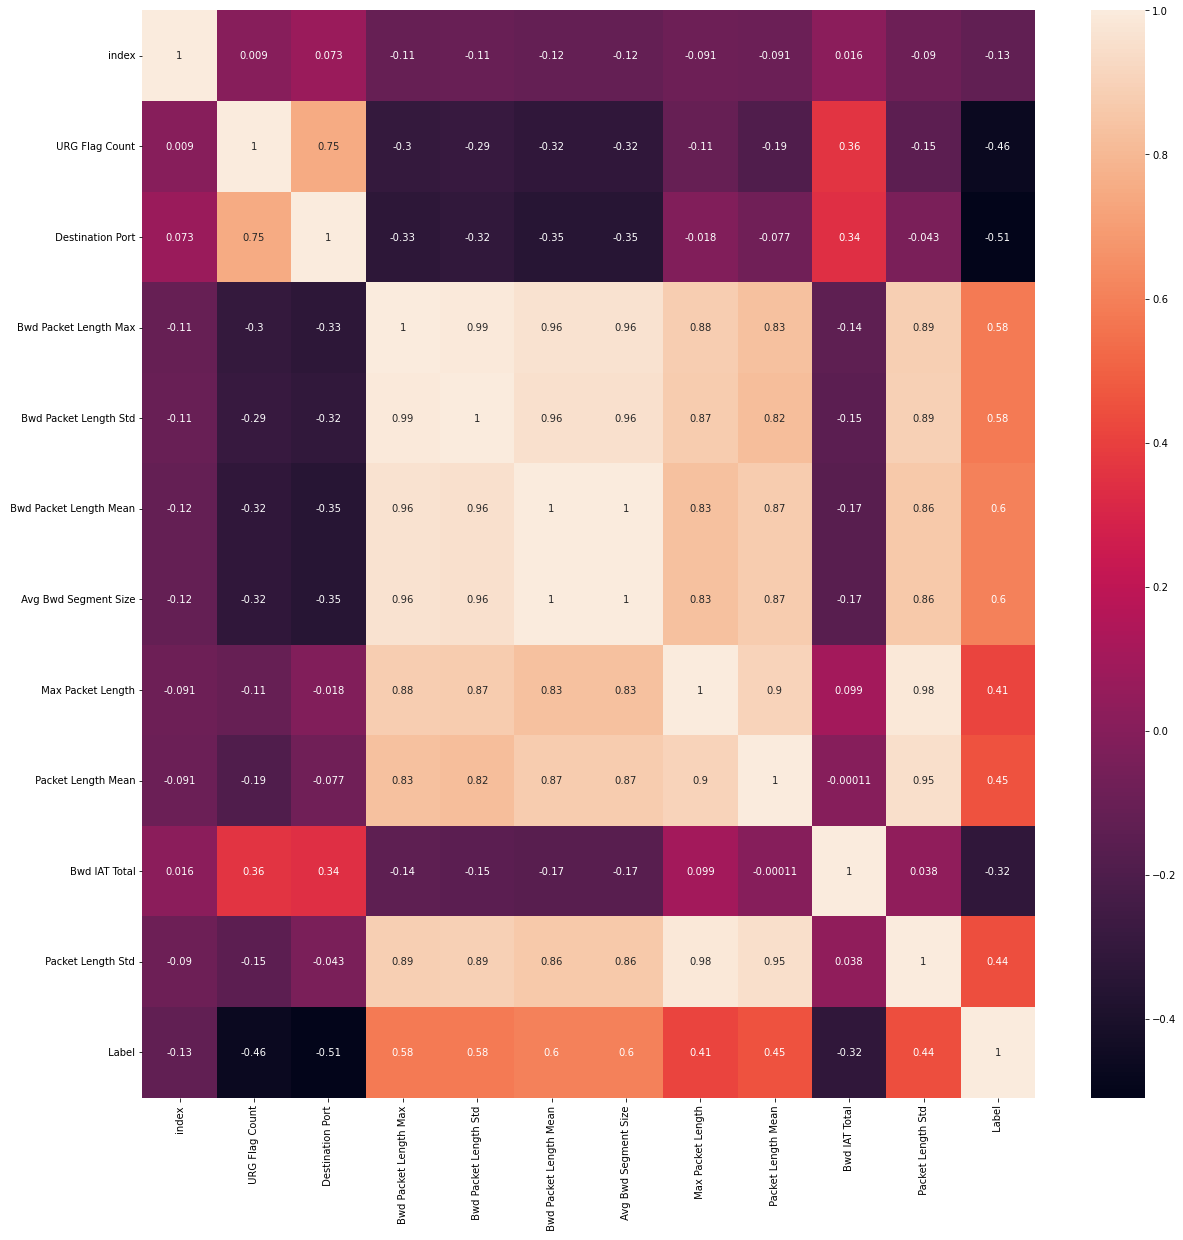

In [8]:
dataProcessor.print_correlation_matrix(corrDataframe)

In [9]:
corrDataframe = corrDataframe.drop(["index"], axis=1)
corrDataframe

,URG Flag Count,Destination Port,Bwd Packet Length Max,Bwd Packet Length Std,Bwd Packet Length Mean,Avg Bwd Segment Size,Max Packet Length,Packet Length Mean,Bwd IAT Total,Packet Length Std,Label
0,0.0,0.837225,0.000000,0.0,0.000000,0.000000,0.000514,0.003098,0.0,0.0,0
1,1.0,0.840109,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
2,1.0,0.840124,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
3,1.0,0.705548,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
4,0.0,0.837194,0.000000,0.0,0.000000,0.000000,0.000514,0.003098,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
225736,1.0,0.936550,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
225737,1.0,0.936611,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
225738,1.0,0.936565,0.000514,0.0,0.001034,0.001034,0.000514,0.003098,0.0,0.0,0
225739,0.0,0.935772,0.000000,0.0,0.000000,0.000000,0.000514,0.003098,0.0,0.0,0


## Machine Learning Methods 

In [10]:
import MLMethodBuilder as mlbuilder;
mlBuilder = mlbuilder.MLMethodBuilder(corrDataframe)

Generic Method Builder is invoke.
ML Builder is invoke


In [11]:
mlBuilder.NaiveBayes()

Data will split.
NaiveBayes Results calculated in: 0.04580807685852051 s
Confusion Matrix of Naive Bayes Classifier: 
 [[10431  9136]
 [    0 25582]]


Calculated Metrics: 

accuracy: 0.7976477884338523

precision: 1.0

recall: 0.7368512011060545

f1 score: 0.8484908789386401


## Using Differential Privacy 

In [12]:
mlBuilder.DifferentialNaiveBayes()

Differential NaiveBayes Results calculated in: 0.039804935455322266 s
Confusion Matrix of Naive Bayes Classifier: 
 [[18455  1112]
 [ 9330 16252]]


Calculated Metrics: 

accuracy: 0.7687213448802853

precision: 0.6352904385896333

recall: 0.9359594563464639

f1 score: 0.7568574488893028


/Users/batuhanduyuler/opt/anaconda3/envs/batuenv/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:101: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)


from diffprivlib.models import KMeans
clf = KMeans(2, epsilon=1.5, bounds=(0, 1))
clf.fit(corrDataframe.iloc[:200000, :9].values)
predictions = clf.predict(corrDataframe.iloc[200000:, :9].values)

sum(predictions - abs(corrDataframe.iloc[200000:, 10:].values.ravel())) / len(predictions)

## Convolutional Neural Networks (1D) 

SYN Flood, Monday Working Hours, Friday Working Hours datasını inceleceyeğiz.<br>
Burada Friday Working Hours veri setini Train/Validation için kullanılırken<br>
Monday Working Hours (DDoS Free) ve SYN Flood datalarını test için kullanacağız<br><br>
Ancak SYN Flood, Friday Working Hours ve Monday Dataset farklı featurelar içerdiğinden, Friday Working Hoursun sahip olduğu ortak bir feature set yaratmalıyız.

In [41]:
mondayDataset: pd.DataFrame = pd.read_csv(
    "../verisetleri/Monday-WorkingHours.pcap_ISCX.csv", low_memory=False)
    
fridayDataSet: pd.DataFrame = pd.read_csv(
    "../verisetleri/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)
    
synDataset : pd.DataFrame = pd.read_csv("../verisetleri/01-12/Syn.csv", low_memory = False)

In [58]:
def find_common_features(my_A, my_B, my_C):
   my_s1 = set(my_A)
   my_s2 = set(my_B)
   my_s3 = set(my_C)
   my_set1 = my_s1.intersection(my_s2)
   output_set = my_set1.intersection(my_s3)
   output_list = list(output_set)
   return output_list

In [59]:
def process_basics_for_data(dataframe : pd.DataFrame) -> pd.DataFrame :
    dataProcessor: DataProcessor = DataProcessor(dataframe)
    scaledData = dataProcessor.min_max_scaler(dataframe)
    encodedScaledData = dataProcessor.label_encoder(scaledData)
    return encodedScaledData

In [60]:
commonColumns = find_common_features(mondayDataset.columns, fridayDataSet.columns, synDataset.columns)
mondayDataset = mondayDataset[commonColumns]
fridayDataSet = fridayDataSet[commonColumns]
synDataset = synDataset[commonColumns]


In [62]:
processedMonday = process_basics_for_data(mondayDataset)
processedFriday = process_basics_for_data(fridayDataSet)
processedSyn = process_basics_for_data(synDataset)

In [63]:
commonColumns = find_common_features(processedMonday.columns, processedFriday.columns, processedSyn.columns)
processedMonday = processedMonday[commonColumns]
processedFriday = processedFriday[commonColumns]
processedSyn = processedSyn[commonColumns]

In [121]:
from DLMethodBuilder import DLMethodBuilder

In [122]:
dlBuilderWithFullData = DLMethodBuilder(processedFriday)
dlBuilderWithFullData.ConvolutionalNeuralNetwork()

Generic Method Builder is invoke.
DL Builder is invoke
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 61, 64)            256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 59, 32)            6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 929       
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [123]:
dlBuilderWithFullData.start_to_compile(epochNum = 3, batchSize = 256)

Data will split.
Train on 180592 samples, validate on 45149 samples
Epoch 1/3
180592/180592 [==============================] - 94s 520us/step - loss: 0.4534 - accuracy: 0.5682 - val_loss: 0.4193 - val_accuracy: 0.5666
Epoch 2/3
180592/180592 [==============================] - 96s 529us/step - loss: 0.3776 - accuracy: 0.6233 - val_loss: 0.3108 - val_accuracy: 0.8663
Epoch 3/3
180592/180592 [==============================] - 93s 512us/step - loss: 0.2073 - accuracy: 0.9536 - val_loss: 0.1240 - val_accuracy: 0.9660
1D CNN Results calculated in: 282.9232761859894 s


In [124]:
processMondayTest = processedMonday.drop([" Label"], axis = 1)[:10000]
processedSynTest = processedSyn.drop([" Label"], axis = 1)[:10000]

MondayTestLabel = np.array(processedMonday[" Label"][:10000])
SynTestLabel = np.array(processedSyn[" Label"][:10000])

In [125]:
predictionsMonday = dlBuilderWithFullData.predict(processMondayTest)
predictionsSyn = dlBuilderWithFullData.predict(processedSynTest)

In [135]:
def labelPredictions(predictionList: np.array) -> list: 
    labeledPredictions = []
    
    threshold = np.mean(predictionList) + 1 * np.std(predictionList)
    for elem in predictionList : 
        if elem > threshold:
            labeledPredictions.append(1)
        else:
            labeledPredictions.append(0)
    return labeledPredictions

In [136]:
labeledMondayPredictions = labelPredictions(predictionsMonday)
labeledSynPredictions = labelPredictions(predictionsSyn)

In [137]:
from sklearn.metrics import accuracy_score
print('Accuracy: %f' % (accuracy_score(labeledMondayPredictions, MondayTestLabel)*100))
print('Accuracy: %f' % (accuracy_score(labeledSynPredictions, MondayTestLabel)*100))

Accuracy: 81.830000
Accuracy: 77.560000
